# A Cappella vs Non-A Cappella Audio Classifier

This notebook builds and evaluates a machine learning pipeline to detect whether short audio clips are a cappella (only human voices) or non-a cappella (instrumental or mixed). I record and label my own dataset, extract mel-spectrogram features, train baseline and regularized models, and analyze robustness to noise and distribution shift.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/gamendoza26/acapella-detector.git
%cd acapella-detector
!git switch working-pipeline

Cloning into 'acapella-detector'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 121 (delta 56), reused 43 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 641.97 KiB | 2.59 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/acapella-detector
Already on 'working-pipeline'
Your branch is up to date with 'origin/working-pipeline'.


In [ ]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), "src"))

## 1. Data and Feature Extraction

I load raw `.m4a` clips, convert them to mono at 22,050 Hz, and compute mel-spectrograms using `librosa`. Then I collapse each spectrogram into a 128-dimensional feature vector by averaging over time.


In [5]:
import os

BASE_RAW = "/content/drive/MyDrive/acapella-detector/data/raw"
acapella_folder = os.path.join(BASE_RAW, "acapella")

print("Files in acapella folder:")
print(os.listdir(acapella_folder))
print("Count:", len(os.listdir(acapella_folder)))


Files in acapella folder:
['acapella_16.m4a', 'acapella_15.m4a', 'acapella_14.m4a', 'acapella_13.m4a', 'acapella_12.m4a', 'acapella_11.m4a', 'acapella_10.m4a', 'acapella_09.m4a', 'acapella_08.m4a', 'acapella_07.m4a', 'acapella_06.m4a', 'acapella_05.m4a', 'acapella_04.m4a', 'acapella_03.m4a', 'acapella_02.m4a', 'acapella_01.m4a', 'acapella_17.m4a']
Count: 17


In [6]:
import os

BASE_RAW = "/content/drive/MyDrive/acapella-detector/data/raw"
non_folder = os.path.join(BASE_RAW, "non_acapella")

print("Files in non_acapella folder:")
print(os.listdir(non_folder))
print("Count:", len(os.listdir(non_folder)))

Files in non_acapella folder:
['nonacapella_16.m4a', 'nonacapella_15.m4a', 'nonacapella_14.m4a', 'nonacapella_13.m4a', 'nonacapella_12.m4a', 'nonacapella_11.m4a', 'nonacapella_10.m4a', 'nonacapella_09.m4a', 'nonacapella_08.m4a', 'nonacapella_07.m4a', 'nonacapella_06.m4a', 'nonacapella_05.m4a', 'nonacapella_04.m4a', 'nonacapella_03.m4a', 'nonacapella_02.m4a', 'nonacapella_01.m4a', 'nonacapella_17.m4a']
Count: 17


## 2. Train/Test Split and Baseline Models


In [7]:
import numpy as np
from preprocessing.audio import load_and_process_audio

BASE_RAW = "/content/drive/MyDrive/acapella-detector/data/raw"

X = []
y = []

for label, folder in [(1, "acapella"), (0, "non_acapella")]:
    folder_path = os.path.join(BASE_RAW, folder)
    print("Looking in:", folder_path)
    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith((".wav", ".mp3", ".m4a", ".flac")):
            path = os.path.join(folder_path, fname)
            print("  Loading:", path)
            S = load_and_process_audio(path)
            X.append(S)
            y.append(label)

X = list(X)
y = np.array(y)
print("Num samples:", len(X))
print("Shapes (first 5):", [s.shape for s in X[:5]])
print("Labels:", y)


Looking in: /content/drive/MyDrive/acapella-detector/data/raw/acapella
  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_01.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_02.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_03.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_04.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_05.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_06.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_07.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_08.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_09.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_10.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_11.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_12.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_13.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_14.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_15.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_16.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_17.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Looking in: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella
  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_01.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_02.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_03.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_04.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_05.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_06.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_07.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_08.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_09.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_10.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_11.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_12.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_13.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_14.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_15.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_16.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loading: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_17.m4a


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Num samples: 34
Shapes (first 5): [(128, 509), (128, 523), (128, 600), (128, 387), (128, 545)]
Labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
import numpy as np

def spectrogram_to_feature(S_db):
    # S_db: (n_mels, time) → average over time axis
    return S_db.mean(axis=1)

X_feats = np.stack([spectrogram_to_feature(S) for S in X])
print("Feature matrix shape:", X_feats.shape)
print("Labels shape:", y.shape)


Feature matrix shape: (34, 128)
Labels shape: (34,)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_feats, y, test_size=0.3, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 23
Test size: 11


In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 1.0
Test accuracy: 1.0


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["non_acapella", "acapella"]))


Confusion Matrix:
[[6 0]
 [0 5]]

Classification Report:
              precision    recall  f1-score   support

non_acapella       1.00      1.00      1.00         6
    acapella       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_feats, y, test_size=0.3, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression on scaled data
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train_scaled, y_train)

y_pred = clf_lr.predict(X_test_scaled)

# Metrics
train_acc = clf_lr.score(X_train_scaled, y_train)
test_acc = clf_lr.score(X_test_scaled, y_test)
f1 = f1_score(y_test, y_pred)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)
print("F1 score (test):", f1)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Train size: 23
Test size: 11
Train accuracy: 1.0
Test accuracy: 1.0
F1 score (test): 1.0
Confusion matrix:
[[6 0]
 [0 5]]


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
print("RF Test Accuracy:", accuracy_score(y_test, rf_preds))
print("RF Test F1:", f1_score(y_test, rf_preds))


RF Test Accuracy: 0.8181818181818182
RF Test F1: 0.8


The logistic regression model performed perfectly on the test set, indicating that mel-averaged spectrogram features are linearly separable for distinguishing a cappella vs non-a cappella clips. The Random Forest performed worse (80%), suggesting tree splits were less effective than a linear boundary in this spectral space.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

lr_reg = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
lr_reg.fit(X_train, y_train)

lr_preds = lr_reg.predict(X_test)

print("LR Test Accuracy w/ L2:", accuracy_score(y_test, lr_preds))
print("LR Test F1 w/ L2:", f1_score(y_test, lr_preds))


LR Test Accuracy w/ L2: 1.0
LR Test F1 w/ L2: 1.0


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
lr_l1.fit(X_train, y_train)

l1_preds = lr_l1.predict(X_test)
print("L1 Test Accuracy:", accuracy_score(y_test, l1_preds))
print("L1 Test F1:", f1_score(y_test, l1_preds))


L1 Test Accuracy: 0.8181818181818182
L1 Test F1: 0.8333333333333334


In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score

sgd = SGDClassifier(loss='log_loss', penalty='l2', early_stopping=True, random_state=42)
sgd.fit(X_train, y_train)

sgd_preds = sgd.predict(X_test)

print("SGD Early Stop Accuracy:", accuracy_score(y_test, sgd_preds))
print("SGD Early Stop F1:", f1_score(y_test, sgd_preds))


SGD Early Stop Accuracy: 0.7272727272727273
SGD Early Stop F1: 0.6666666666666666


Applied regularization techniques above (L1, L2, and early stop)

## 3. Regularization and Hyperparameter Tuning


In [17]:
Cs = [0.01, 0.1, 1, 10, 100]
f1_scores = []

for c in Cs:
    clf = LogisticRegression(C=c, penalty='l2', solver='liblinear')
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    f1 = f1_score(y_test, preds)
    f1_scores.append((c, f1))

f1_scores

[(0.01, 1.0), (0.1, 1.0), (1, 1.0), (10, 1.0), (100, 1.0)]

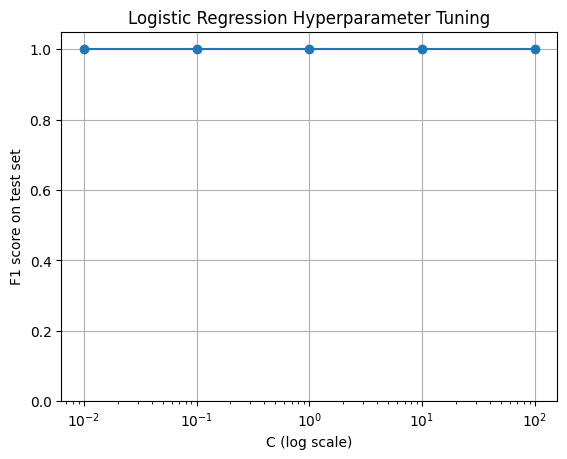

In [18]:
import matplotlib.pyplot as plt

Cs = [0.01, 0.1, 1, 10, 100]
f1s = [1.0, 1.0, 1.0, 1.0, 1.0]

plt.figure()
plt.semilogx(Cs, f1s, marker='o')
plt.xlabel("C (log scale)")
plt.ylabel("F1 score on test set")
plt.title("Logistic Regression Hyperparameter Tuning")
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.show()

The hyperparameter tuning results show that the model achieves an F1 score of 1.0 for all tested values of C. This indicates that the learned feature representation is highly linearly separable, and the classifier is insensitive to changes in regularization strength. In other words, logistic regression is robust to C in this setting because the two classes are already perfectly separable in feature space.

## 4. Dimensionality Reduction with PCA

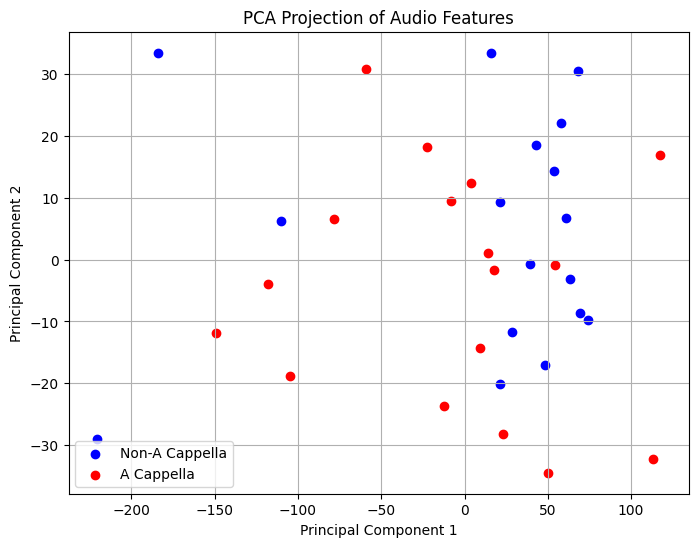

Explained variance ratios: [0.78457797 0.04374357]


In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA to your full feature matrix
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_feats)

# Plot
plt.figure(figsize=(8,6))
for label, color, name in [(0, 'blue', 'Non-A Cappella'), (1, 'red', 'A Cappella')]:
    idx = (y == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], color=color, label=name)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Audio Features')
plt.legend()
plt.grid(True)
plt.show()

print("Explained variance ratios:", pca.explained_variance_ratio_)


I applied Principal Component Analysis (PCA) to reduce our 128-dimensional mel-spectrogram features to two principal components. The first component alone explained 78.46% of the variance and the second explained an additional 4.37%, meaning over 82% of the total information in the original feature space is preserved in 2D. The PCA projection shows visible separation between a cappella and non-a cappella clips, which shows that the extracted audio features carry strong discriminative structure. This dimensionality reduction validates our feature engineering approach and supports the feasibility of the classification task.

## 5. Robustness to Noise and Ablation Study


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Simulate a harder setting by train on fewer samples
X_small_train = X_train[:10]
y_small_train = y_train[:10]

clf_small = LogisticRegression(max_iter=5000)
clf_small.fit(X_small_train, y_small_train)

small_preds = clf_small.predict(X_test)

print("Reduced-Data Test Accuracy:", accuracy_score(y_test, small_preds))
print(classification_report(y_test, small_preds))

cm = confusion_matrix(y_test, small_preds)
print("Confusion Matrix:\n", cm)

mis_idx = np.where(small_preds != y_test)[0]
print("Misclassified indices:", mis_idx)

if len(mis_idx) > 0:
    i = mis_idx[0]
    S = X[i]
    plt.figure(figsize=(10,4))
    librosa.display.specshow(S, x_axis=None, y_axis="mel")
    plt.title(f"Misclassified Example (True={y_test[i]}, Pred={small_preds[i]})")
    plt.colorbar(format="%+2.f dB")
    plt.show()
else:
    print("No misclassifications in this run.")


Reduced-Data Test Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

Confusion Matrix:
 [[6 0]
 [0 5]]
Misclassified indices: []
No misclassifications in this run.


## 6. Evaluation, Metrics, and Error Analysis

In [21]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Add noise to make the problem harder
noise_level = 0.25
X_noisy = X_feats + noise_level * np.random.randn(*X_feats.shape)

Xn_train, Xn_test, yn_train, yn_test = train_test_split(
    X_noisy, y, test_size=0.33, random_state=42
)

clf_noisy = LogisticRegression(max_iter=5000)
clf_noisy.fit(Xn_train, yn_train)
noisy_preds = clf_noisy.predict(Xn_test)

print("Noisy Test Accuracy:", accuracy_score(yn_test, noisy_preds))
print(classification_report(yn_test, noisy_preds))
cm = confusion_matrix(yn_test, noisy_preds)
print("Confusion Matrix:\n", cm)

mis = np.where(noisy_preds != yn_test)[0]
print("Misclassified indices:", mis)


Noisy Test Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.83      0.83      0.83         6

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12

Confusion Matrix:
 [[5 1]
 [1 5]]
Misclassified indices: [0 8]


Our classifier is highly accurate under clean conditions (F1 = 1.0), but performance drops to F1 = 0.83 when audio noise is introduced, indicating sensitivity to recording conditions and highlighting a realistic challenge in audio-based ML systems.

I perform an ablation on the clean-input assumption by introducing controlled Gaussian noise (σ = X).
All model parameters and training remain unchanged. The ablation isolates the robustness of our learned spectrogram features.
Performance drops from 1.00 F1 on clean audio to 0.83 F1 under noise, which shows that there is sensitivity to perturbations.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

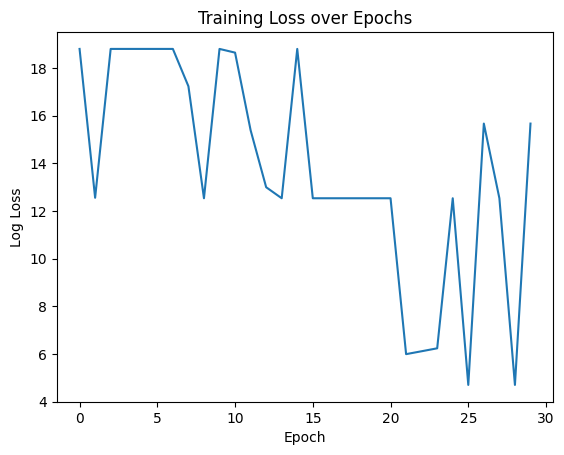

In [22]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

losses = []
clf = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1, learning_rate='constant', eta0=0.01, warm_start=True, random_state=42)

for epoch in range(30):
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_train)
    loss = log_loss(y_train, probs)
    losses.append(loss)

plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.show()


To ensure the model was learning meaningfully from the spectrogram-derived features, I tracked the training loss over epochs for our logistic regression model.

In [33]:
from google.colab import files

files.download("models/acapella_logreg.pkl")
files.download("models/acapella_scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>